This notebook contains the second step of data preprocessing for the MIT ADSP capstone project on facial emotion detection

Performed here:
- Use image hashing to determine if any duplicate images are present in the dataset
- Store unique (duplicates dropped) images for subsequent data processing

Google Colab setup

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set main directory
main_directory = '/content/drive/MyDrive/facial-emotion-detection-cnn'

Mounted at /content/drive


Get some helpful tools

In [ ]:
# Get imagehash to find duplicates in dataset (to remove duplicates before training)
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 26.4 MB/s eta 0:00:00


In [ ]:
# Import the libraries
import os
from pathlib import Path
import shutil
import glob
import imagehash
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Access 'common_functions.py' file

In [ ]:
# Specify path to common functions python file
project_path = Path(os.path.join(main_directory, 'notebooks'))
common_functions_file = 'common_functions.py'

# Construct the full path of common functions python file
full_path = project_path / common_functions_file

# Use exec to run the file
exec(open(full_path).read())

Set location to store preprocessed unique image dataset (after duplicates are removed in this notebook below)

In [ ]:
# Specify path to preprocessed face detection dataset
high_confidence_directory = os.path.join(main_directory, 'data/face_detection/high_confidence_images')

# Define the base directory for the new unique images
unique_image_directory = os.path.join(main_directory, 'data/unique_images')

# Create the new directory if it doesn't exist
os.makedirs(unique_image_directory, exist_ok=True)

Search for duplicate images in train/validation datasets (exclude test data to avoid data leakage). Calculate the hash values of all images and store in a dictionary 'master_hash_dict' which contains all hash values with their corresponding filepaths. This dictionary will record all duplicate filepaths associated with a given image hash value.

WARNING: Slow time bottleneck. Store calculated image hash values in master dictionary with filepath

In [ ]:
# Function to calculate hash value for an image file
def calculate_hash(image_path):
    with Image.open(image_path) as img:
        return imagehash.dhash(img)

# Directories to traverse (exclude test dataset to avoid data leakage)
directories = ['train', 'validation']

# Emotion categories
emotions = ['happy', 'sad', 'neutral', 'surprise']

# Master dictionary to store all hash values with duplicates
master_hash_dict = defaultdict(list)

# Loop through all directories and subdirectories
for directory in directories:
    for emotion in emotions:
        # Directory containing the images
        image_directory = os.path.join(high_confidence_directory, directory, emotion)

        # Loop through all image files in the directory
        for root, dirs, files in os.walk(image_directory):
            for filename in files:
                if filename.endswith((".jpg", ".png")):
                    # Get the full path of the image file
                    image_path = os.path.join(root, filename)

                    # Calculate the hash value for the image
                    img_hash = calculate_hash(image_path)

                    # Append the hash value and file path to the master dictionary
                    master_hash_dict[img_hash].append(image_path)

Create a dictionary to store hash values and associated file_paths for any images that were found to be duplicates

In [ ]:
# Create a dictionary to store duplicate hash values and their corresponding file paths
duplicate_hash_dict = defaultdict(list)

# Iterate over the master_hash_dict to filter out hash values with duplicates
for img_hash, file_paths in master_hash_dict.items():
    if len(file_paths) > 1:  # Check if the hash value has duplicates
        duplicate_hash_dict[img_hash] = file_paths

Query: Are there any images that are duplicates but have different emotion class labels? It would be interesting to see if the same image is labeled with different emotions...

In [ ]:
# Dictionary to store hash values with different emotion categories
hash_with_diff_emotion = {}

# Iterate through duplicate_hash_dict
for img_hash, file_paths in duplicate_hash_dict.items():
    # Get the set of emotion categories for images with this hash
    emotion_categories = set(os.path.basename(os.path.dirname(path)) for path in file_paths)

    # Check if there are different emotion categories
    if len(emotion_categories) > 1:
        # Store the hash value along with the different emotion categories
        hash_with_diff_emotion[img_hash] = emotion_categories

# Print hash values with different emotion categories
for img_hash, emotions in hash_with_diff_emotion.items():
    print(f"Hash value: {img_hash}")
    print("Emotion categories:")
    for emotion in emotions:
        print(f"   {emotion}")
    print()

Hash value: 7361f2f4e1dbdb69
Emotion categories:
   surprise
   happy

Hash value: 78fcf4f6d4f0f478
Emotion categories:
   neutral
   happy

Hash value: fc7c3432dc5a565c
Emotion categories:
   surprise
   happy

Hash value: 69f1f171494d5969
Emotion categories:
   surprise
   happy

Hash value: 408c3733b5a7a793
Emotion categories:
   neutral
   sad

Hash value: f0f0e4f45c9cccc8
Emotion categories:
   neutral
   sad



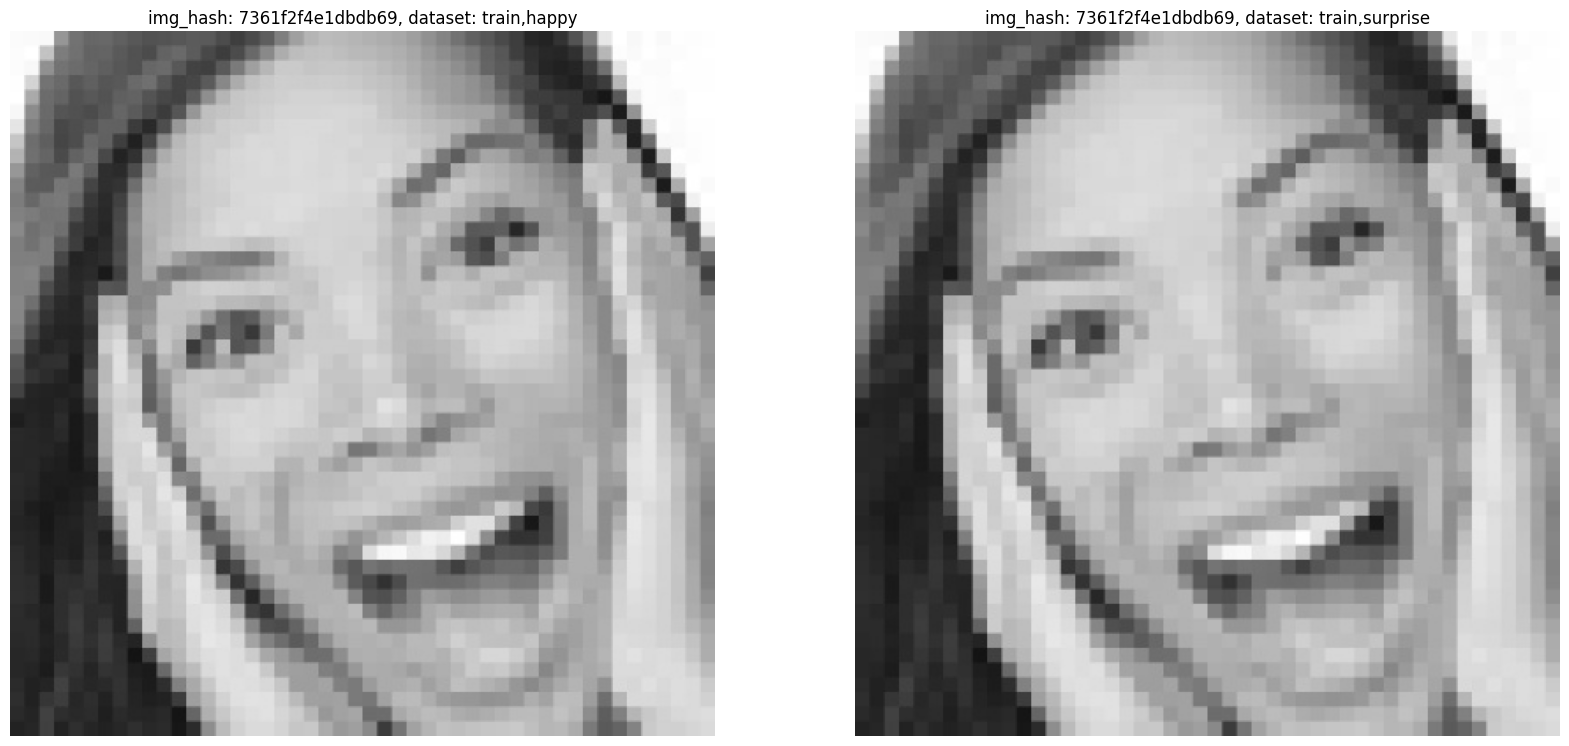

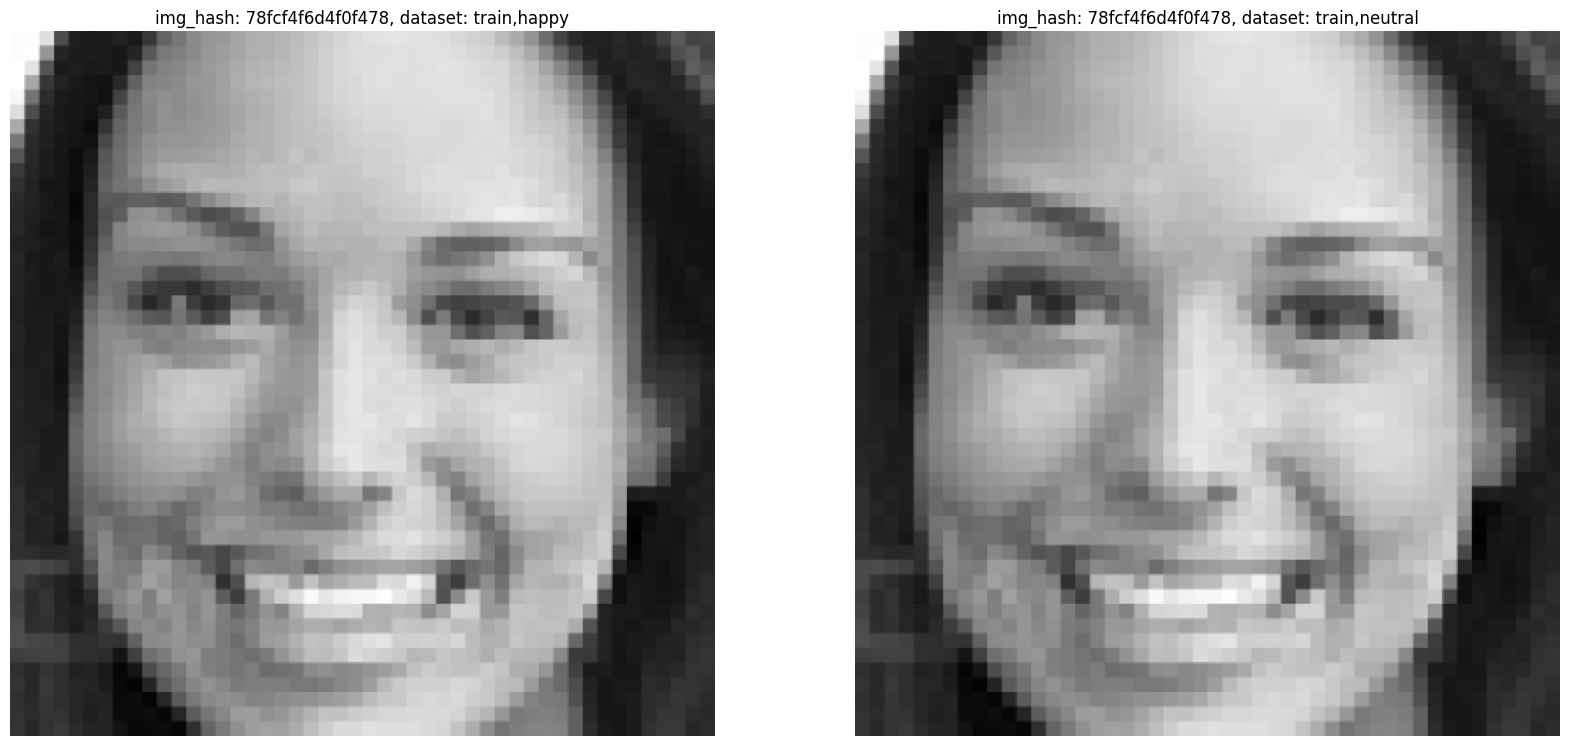

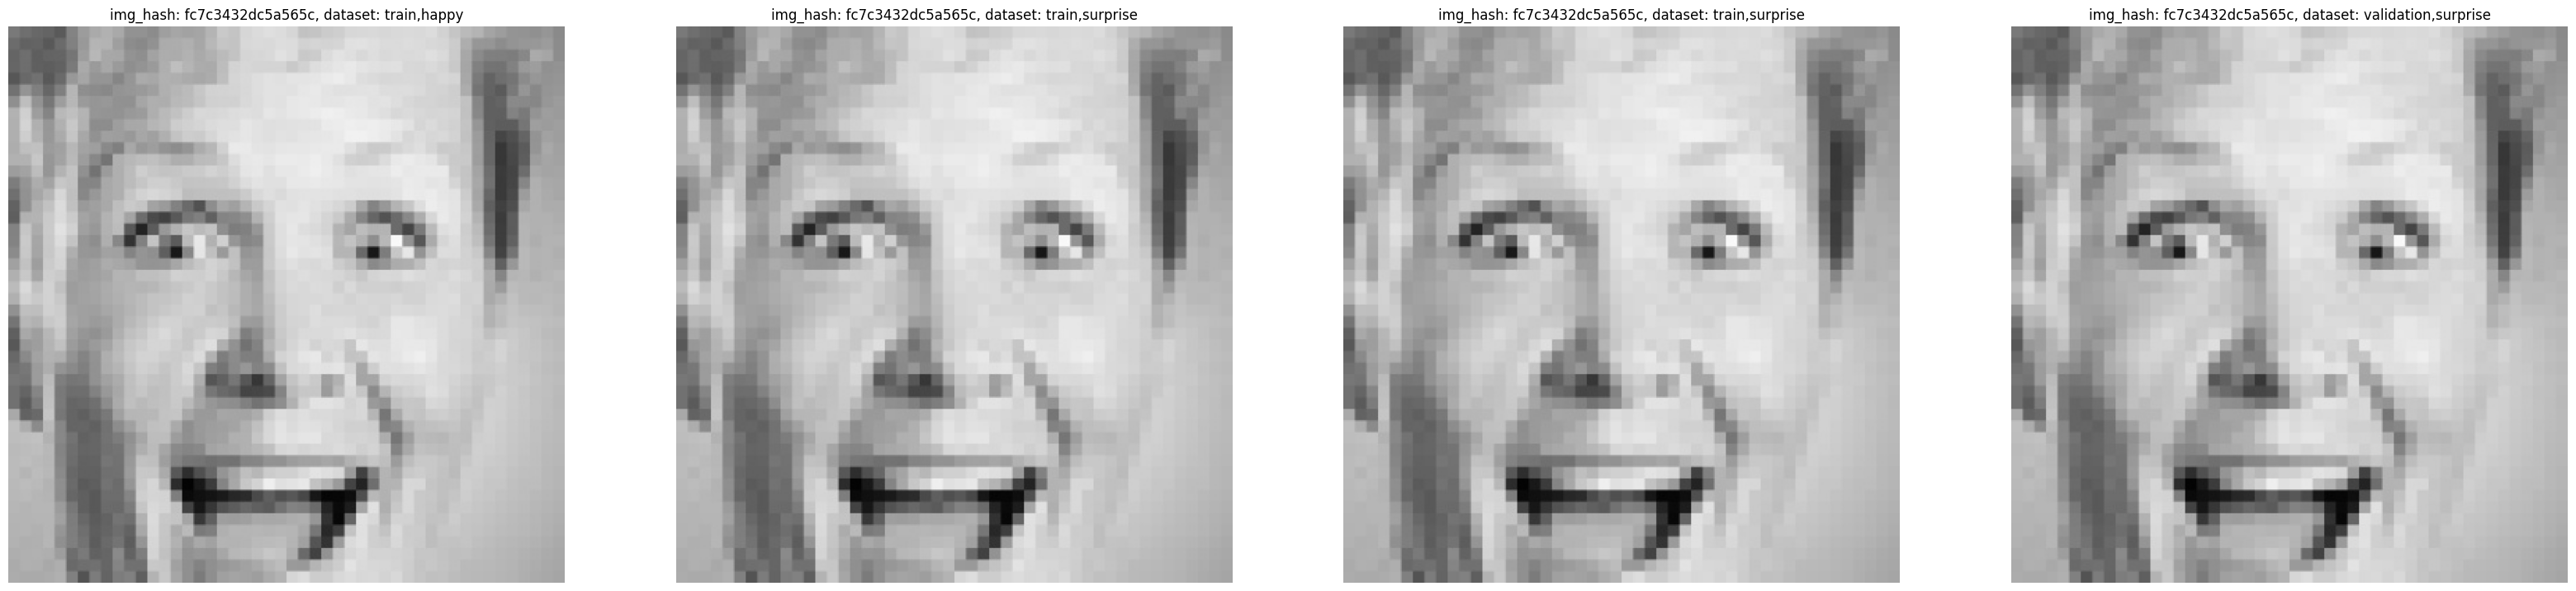

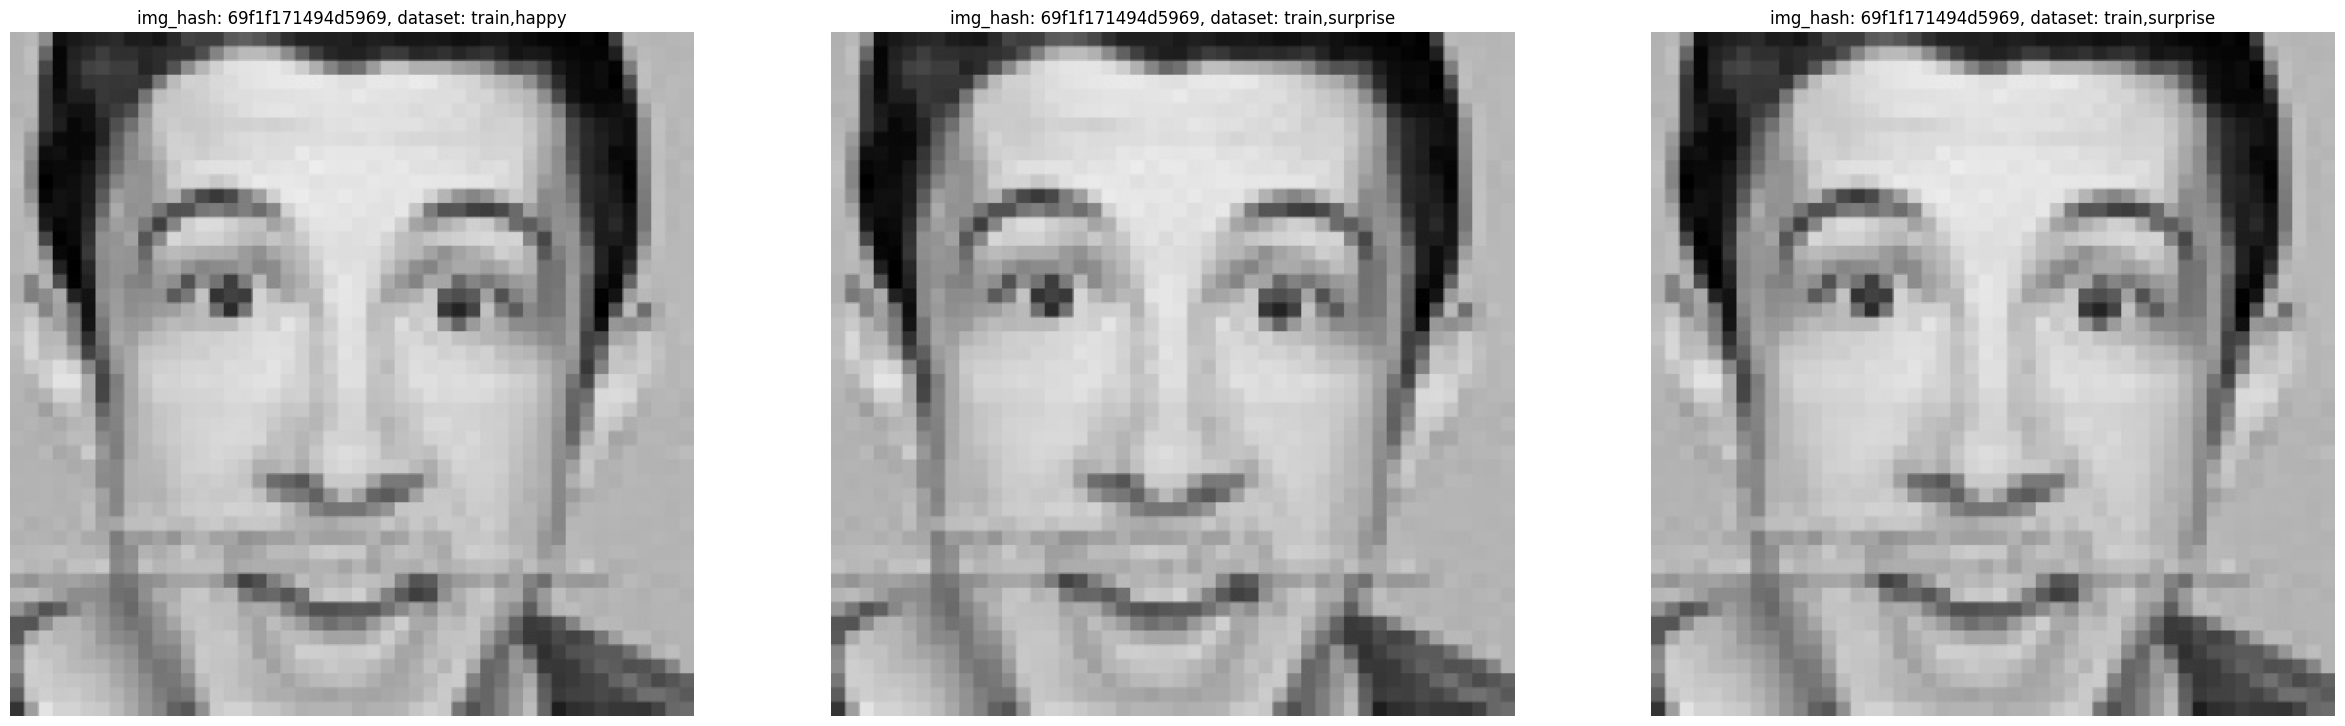

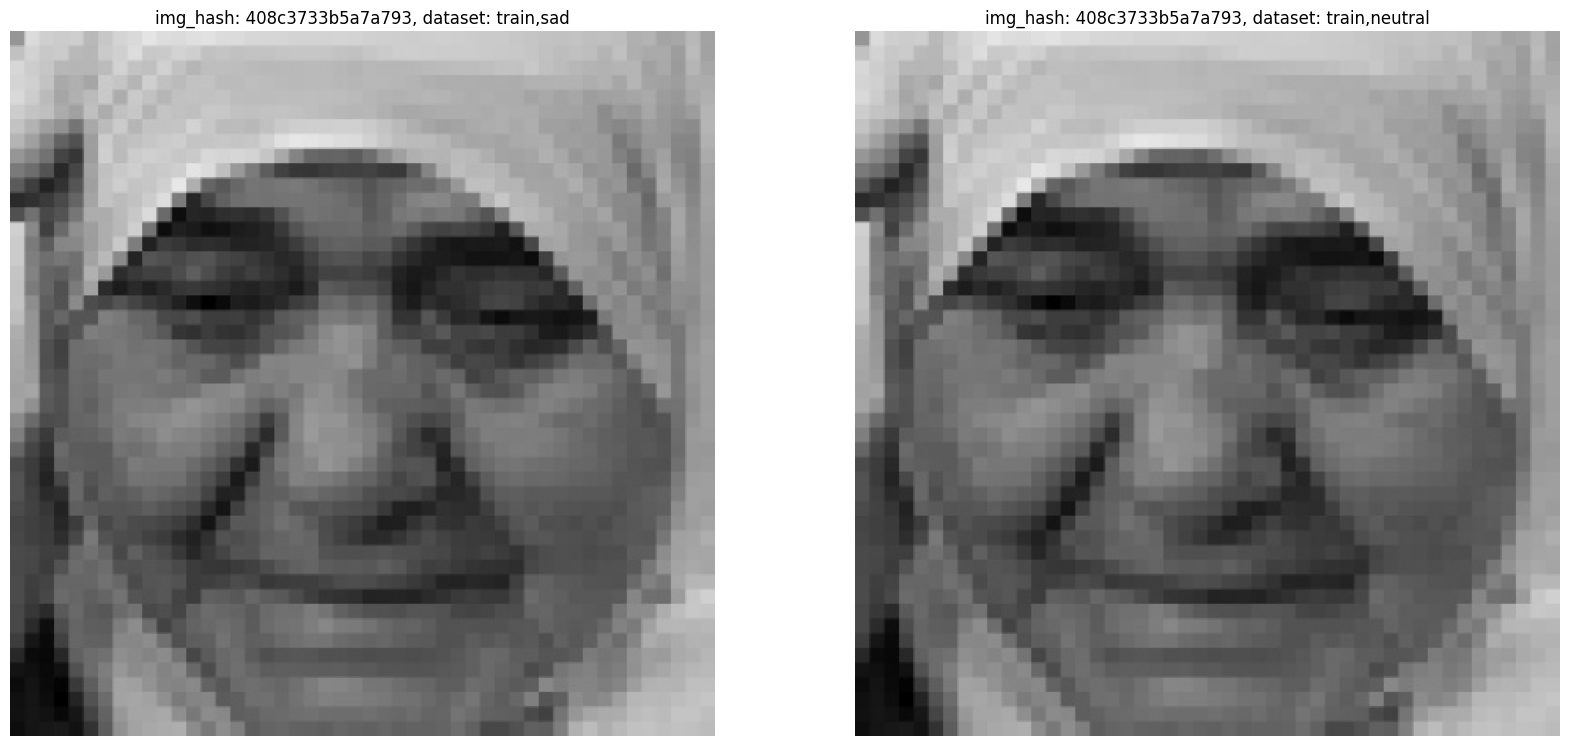

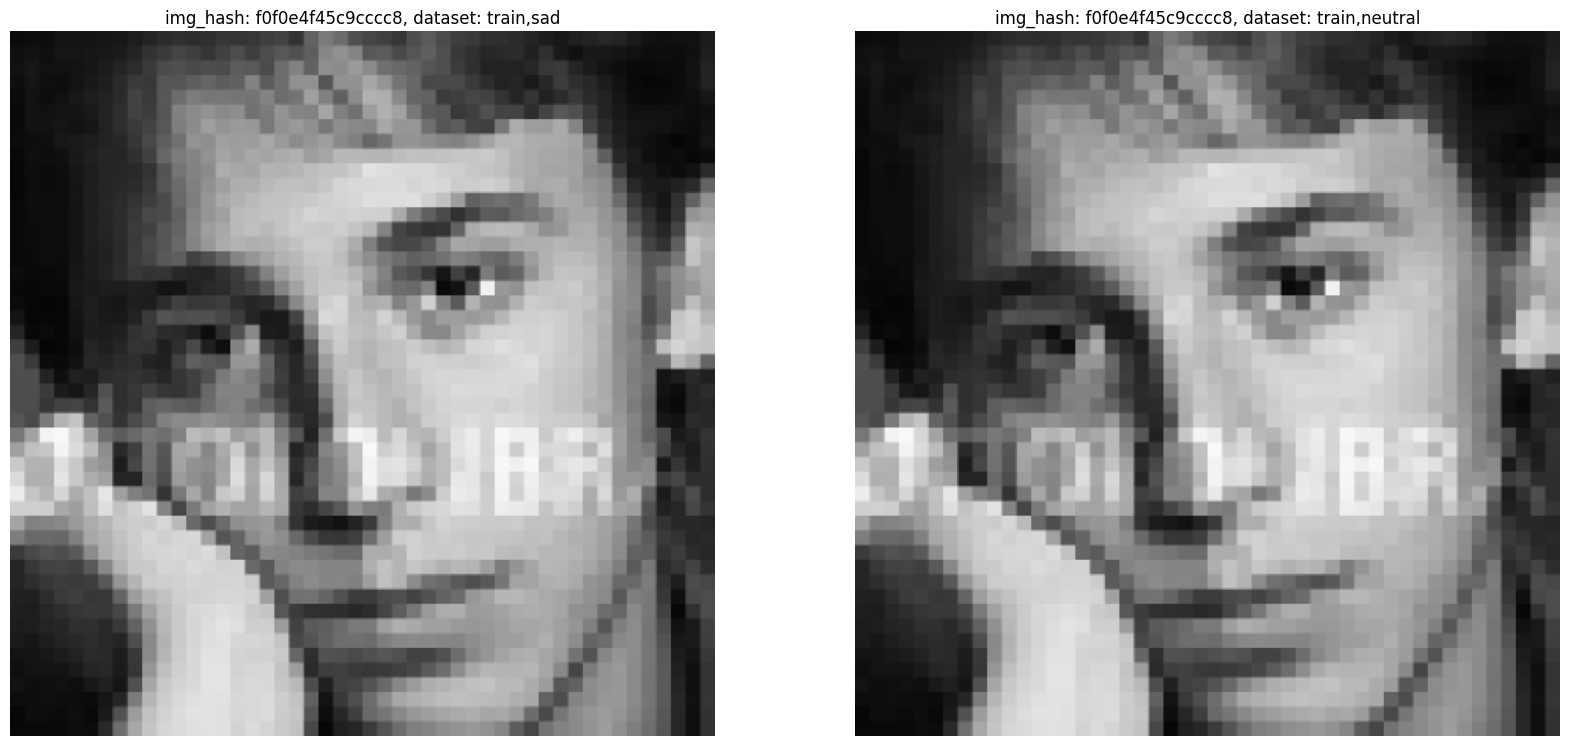

In [ ]:
# Define a function to display images
def display_images(file_paths):
    num_images = len(file_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(10*num_images, 10))
    for i, file_path in enumerate(file_paths):
        with Image.open(file_path) as img:
            axes[i].imshow(img)
            axes[i].axis('off')
            emotion = os.path.basename(os.path.dirname(file_path))
            directory = os.path.basename(os.path.dirname(os.path.dirname(file_path)))
            axes[i].set_title(f'img_hash: {img_hash}, dataset: {directory},{emotion}')
    plt.show()

# Iterate over the img_hash values in hash_with_diff_emotion
for img_hash in hash_with_diff_emotion.keys():
    # Get the file paths associated with the img_hash from master_hash_dict
    file_paths = master_hash_dict[img_hash]
    # Display the images
    display_images(file_paths)

**Observations:** Sure, it's possible to be both happy and surprised at the same time. It would be interesting to develop some nuance in the emotion classes, but that is beyond the scope of our assigned task at the moment. Since our aim is to develop a model that can exclusively differentiate between a specific set of four emotion classes, these duplicate images with different emotion labels pose a problem for our assigned task. These image labels are unreliable since they have conflicting emotion labels. They will be excluded in the training, but note that it will be interesting to revisit the quality and subjectivity of the labels.  

Create a new dictionary 'filtered_duplicate_hash_dict' which contains all duplicate images but excludes the images above with conflicting labels.

In [ ]:
# Create a new dictionary to store filtered duplicate hash values
filtered_duplicate_hash_dict = {}

# Iterate over the duplicate hash dictionary
for img_hash, file_paths in duplicate_hash_dict.items():
    # Check if the hash value is not present in hash_with_diff_emotion_dhash
    if img_hash not in hash_with_diff_emotion:
        # Add the hash value and its file paths to the filtered dictionary
        filtered_duplicate_hash_dict[img_hash] = file_paths

Query: Are there images that are duplicates belonging to both train and validation datasets? For example, is the same image used in train/happy and validation/happy?

Create two new dictionaries: duplicates_diff_dict which contains duplicates across train/validation datasets, and duplicates_same_dict which contains duplicates within the same /train or /validation datasets

In [ ]:
# Initialize dictionaries to store duplicates across different directories and duplicates in the same directory
duplicates_diff_dict = defaultdict(list)
duplicates_same_dict = {}

# Iterate through filtered_duplicate_hash_dict
for img_hash, file_paths in filtered_duplicate_hash_dict.items():
    # Extract the directory paths from file paths
    directories = [os.path.dirname(path) for path in file_paths]
    # Check if there are multiple unique directory paths
    if len(set(directories)) > 1:
        # Add the hash value and file paths to the duplicates_diff_directory dictionary
        duplicates_diff_dict[img_hash].extend(file_paths)
    else:
        # Add the hash value and file paths to the duplicates_same_dict
        duplicates_same_dict[img_hash] = file_paths

Since the training and validation data are not perfectly balanced, drop the duplicates from the directory with higher representation. For example, the proportion of validation/happy is much larger than the proportion of train/happy, so drop the duplicate image from /validation for happy. For the other classes, we will drop the duplicate images from training.

Create a 'selected_representatives' dictionary based on the selection/drop rules just described.

In [ ]:
# Initialize a new dictionary to store representative images
selected_representatives = {}

# Iterate through duplicates_diff_dict
for img_hash, file_paths in duplicates_diff_dict.items():
    # Initialize variables to store representative image and its directory
    representative_image = None
    representative_directory = None

    # Iterate through file paths to find representative image based on the specified rules
    for file_path in file_paths:
        directory = os.path.dirname(file_path)
        emotion = os.path.basename(os.path.dirname(file_path))
        if emotion == 'happy' and 'train' in directory:
            representative_image = file_path
            representative_directory = directory
            break
        elif emotion in ['sad', 'surprise', 'neutral'] and 'validation' in directory:
            representative_image = file_path
            representative_directory = directory
            break

    # If representative image found, add it to the selected_representatives dictionary
    if representative_image is not None:
        selected_representatives[img_hash] = [representative_image]

Keep one representative image from duplicates within the same directory/emotion class

In [ ]:
# Iterate through duplicates_same_dict
for img_hash, file_paths in duplicates_same_dict.items():
    # Add the first file path encountered for each hash value to selected_representatives
    selected_representatives[img_hash] = file_paths[0]

To summarize, we now have:
- master_hash_dict: contains all hash values along with all file_paths associated with that hash value (many duplicates)
- duplicate_hash_dict: contains all hash values that have duplicate images
- filtered_duplicate_hash_dict: all duplicates excluding those that have conflicting emotion labels
- selected_representatives: unique images kept from those that were duplicates

Keep all images from master_hash_dict that are not duplicates. For any images that are duplicates, keep the selected representative that was chosen with rules that could potentially help rebalance the dataset. Create a new dictionary 'unique_images' that will contain all cleaned, unique images that we intend to carry forward to model training. Store all unique images in the designated data directory unique_images specified at the top of this notebook.

In [ ]:
# Initialize a new dictionary to store selected images
unique_images = {}

# Iterate over items in master_hash_dict
for img_hash, file_paths in master_hash_dict.items():
    if len(file_paths) == 1:
        # If the hash value has only one file path, copy it to the final dictionary
        unique_images[img_hash] = file_paths[0]
    elif img_hash in selected_representatives:
        # If the hash value has multiple file paths and it is designated in selected_representatives,
        # copy the designated file path to the final dictionary
        unique_images[img_hash] = selected_representatives[img_hash]

# Iterate over items in unique_images
for img_hash, file_path in unique_images.items():
    # Extract the actual file path if file_path is a list
    if isinstance(file_path, list):
        file_path = file_path[0]

    # Extract the directory and emotion from the file path
    directory, emotion, image_name = file_path.split('/')[-3:]

    # Create the directory structure in the new directory
    unique_image_directory_path = os.path.join(unique_image_directory, directory, emotion)
    os.makedirs(unique_image_directory_path, exist_ok=True)

    # Copy the image file to the new directory
    unique_image_path = os.path.join(unique_image_directory_path, image_name)
    shutil.copy(file_path, unique_image_path)

Copy all High Confidence test images to the Unique_Images test directory

In [ ]:
high_confidence_test_directory = os.path.join(high_confidence_directory, 'test')
unique_images_test_directory = os.path.join(unique_image_directory, 'test')

shutil.copytree(high_confidence_test_directory, unique_images_test_directory, dirs_exist_ok=True)

'/content/drive/MyDrive/facial-emotion-detection-cnn/data/unique_images/test'

Show distribution of Unique_Images dataset

In [ ]:
# Print number of files within the high-confidence image directory
print_number_of_files(unique_image_directory)

Number of .jpg files in /content/drive/MyDrive/facial-emotion-detection-cnn/data/unique_images: 19137
Number of .jpg files in /content/drive/MyDrive/facial-emotion-detection-cnn/data/unique_images/test: 126
Number of .jpg files in /content/drive/MyDrive/facial-emotion-detection-cnn/data/unique_images/test/happy: 31
Number of .jpg files in /content/drive/MyDrive/facial-emotion-detection-cnn/data/unique_images/test/sad: 31
Number of .jpg files in /content/drive/MyDrive/facial-emotion-detection-cnn/data/unique_images/test/neutral: 32
Number of .jpg files in /content/drive/MyDrive/facial-emotion-detection-cnn/data/unique_images/test/surprise: 32
Number of .jpg files in /content/drive/MyDrive/facial-emotion-detection-cnn/data/unique_images/train: 14180
Number of .jpg files in /content/drive/MyDrive/facial-emotion-detection-cnn/data/unique_images/train/happy: 3914
Number of .jpg files in /content/drive/MyDrive/facial-emotion-detection-cnn/data/unique_images/train/sad: 3782
Number of .jpg fil

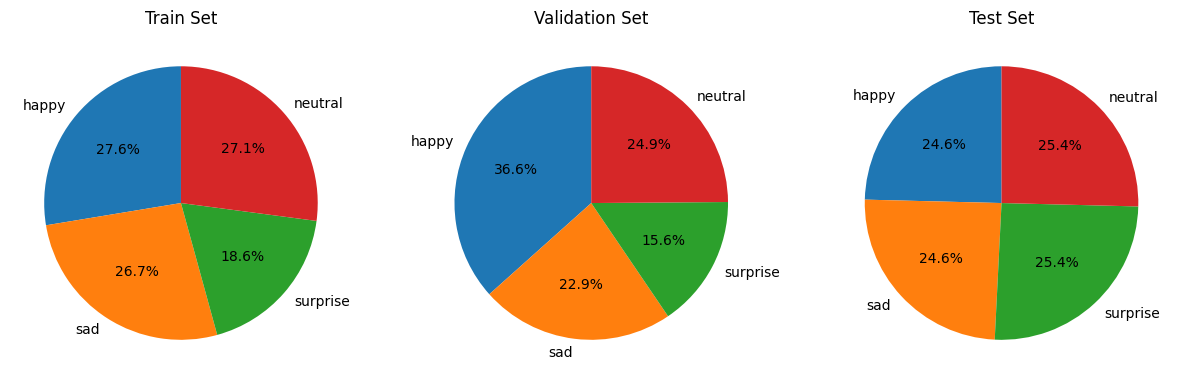



Number Total Images in Train Set: 14180 (74.10%)
Number of Total Images in Validation Set: 4831 (25.24%)
Number of Total Images in Test Set: 126 (0.66%)
Number of Total Images: 19137


In [ ]:
# Show distribution of data in train, validation, and test set
show_pie_charts(unique_image_directory)

**Observations:** Approximately 1K images were removed in total during data preprocessing where either (1) a face was not detected, or (2) duplicate instances of the image were removed. This cleaning procedure has not significantly changed the overall distribution of the data.